In [1]:
import geopandas as gpd

In [2]:
## Reads the eaton_buildings.geojson file produced in this project to a GeoDataFrame  
eaton_buildings_url="https://raw.githubusercontent.com/heather-math/eaton-fire-buildings-query/main/eaton_buildings.geojson"
gdf_eaton_buildings = gpd.read_file(eaton_buildings_url)

In [3]:
## double checking the CRS
gdf_eaton_buildings.crs

<Projected CRS: EPSG:26911>
Name: NAD83 / UTM zone 11N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 120°W and 114°W - onshore and offshore. Canada - Alberta; British Columbia; Northwest Territories; Nunavut. United States (USA) - California; Idaho; Nevada, Oregon; Washington.
- bounds: (-120.0, 30.88, -114.0, 83.5)
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [4]:
## Creates a buffer of 60m, which is approximately 200feet (a common defensive space recommendation for fire prevention)
eaton_buildings_buffered=gdf_eaton_buildings.buffer(60)

In [5]:
## Combine into a single geometry
from shapely import union_all
dissolved=union_all(eaton_buildings_buffered)

In [6]:
## Create a GeoDataFrame for the buildings in the buffered zone
## Note that some of the buffered zone is now outside of the Eaton fire perimeter.  We will clip that later.
gdf_eaton_buildings_buffered=gpd.GeoDataFrame(geometry=[dissolved], crs=gdf_eaton_buildings.crs)

<Axes: >

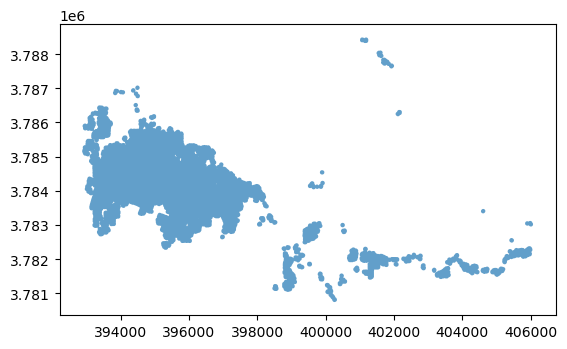

In [7]:
## a quick plot to check
gdf_eaton_buildings_buffered.plot(alpha=0.7)

In [8]:
## defining a GeoDataFrame for the Eaton Fire perimeter from LA County GIS hub's Eaton Fire Perimeter's GeoJSON url 
gdf_firezone=gpd.read_file("https://services.arcgis.com/RmCCgQtiZLDCtblq/arcgis/rest/services/Palisades_and_Eaton_Dissolved_Fire_Perimeters_as_of_20250121/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson")

In [9]:
print(gdf_firezone.head())

   OBJECTID            type   Shape__Area  Shape__Length  \
0         1  Heat Perimeter   2206.265625     270.199719   
1         2  Heat Perimeter  20710.207031     839.204218   
2         3  Heat Perimeter   3639.238281     250.304502   
3         4  Heat Perimeter   1464.550781     148.106792   
4         5  Heat Perimeter   4132.753906     247.960744   

                                            geometry  
0  POLYGON ((-118.10094 34.16681, -118.1009 34.16...  
1  POLYGON ((-118.13596 34.17789, -118.13593 34.1...  
2  POLYGON ((-118.15626 34.18045, -118.15643 34.1...  
3  POLYGON ((-118.08442 34.1809, -118.08445 34.18...  
4  POLYGON ((-118.15659 34.18148, -118.15659 34.1...  


In [10]:
## check firezone data's CRS
print(gdf_firezone.crs)

EPSG:4326


In [11]:
## Set firezone data's CRS to EPSG 26911
gdf_firezone=gdf_firezone.to_crs(epsg=26911)
print(gdf_firezone.crs)

EPSG:26911


In [12]:
## Extract a single geometry from the series in gdf_firezone
fire_geom = gdf_firezone.geometry.union_all()

In [13]:
## This creates a clipped version of the gdf_eaton_buildings_buffered so it lies inside the fire zone
gdf_eaton_buildings_perimeter = gpd.overlay(
    gdf_eaton_buildings_buffered,
    gpd.GeoDataFrame(geometry=[fire_geom], crs=gdf_eaton_buildings_buffered.crs),
    how='intersection'
)

In [14]:
## Just to double check the crs is correct
print(gdf_eaton_buildings_perimeter.crs)

EPSG:26911


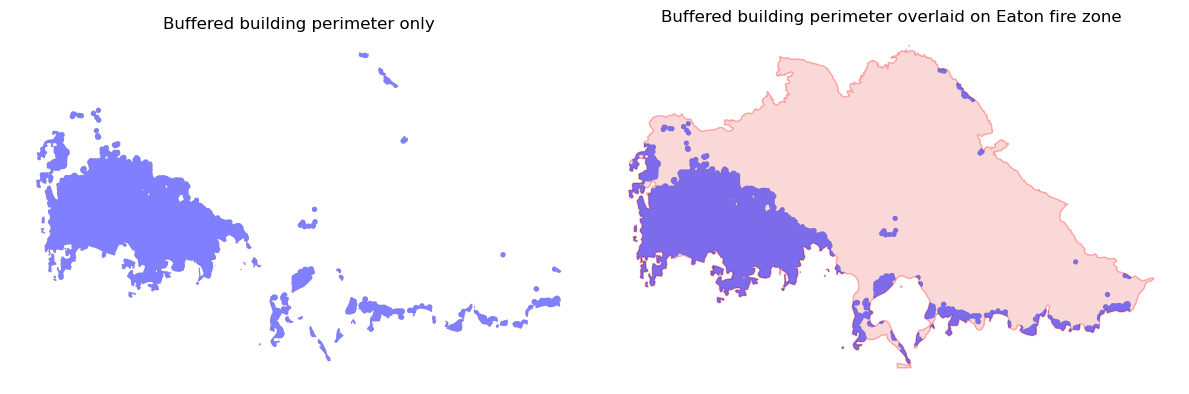

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # wider for side-by-side

# Plot firezone and buffered perimeter on left subplot
gdf_firezone.plot(ax=ax[1], color='lightcoral', edgecolor='red', alpha=0.3)
gdf_eaton_buildings_perimeter.plot(ax=ax[1], color='blue', alpha=0.5, edgecolor='k', linewidth=0.1)
ax[1].set_title("Buffered building perimeter overlaid on Eaton fire zone")
ax[1].axis('off')

# Plot buffered perimeter alone on right subplot
gdf_eaton_buildings_perimeter.plot(ax=ax[0], color='blue', alpha=0.5, edgecolor='k', linewidth=0.1)
ax[0].set_title("Buffered building perimeter only")
ax[0].axis('off')

plt.tight_layout()
plt.savefig("building_perimeter.png", bbox_inches='tight', dpi=300)
plt.show()


In [16]:
gdf_eaton_buildings_perimeter.to_file("eaton_buildings_perimeter60.geojson", driver="GeoJSON")